In [1]:
from google.colab import drive

In [2]:
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
%cd /content/drive/MyDrive/scholar-citation-bias

/content/drive/MyDrive/scholar-citation-bias


In [4]:
!pip3 install -U sentence-transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.0/86.0 KB 3.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 64.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 54.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.1/199.1 KB 21.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 73.2 MB/s eta 0:00:00
  Created wheel for sentence-transformers: filename=sentence_transformers-2.2.2-py3-none-any.whl size=125938 sha256=61f699608c2cc5d8d29baba37d2ad5650d718989beb8ce0b8653e83f3231a6c2
  Stored in directory: /root/.cache/pip/wheels/71/67/06/162a3760c40d74dd40bc855d527008d26341c2b0ecf3e8e11f
Successfully built sentence-transformers


In [5]:
!pip3 install seaborn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [6]:
# Load required dependencies
from torch.utils.data import DataLoader
import math

from sentence_transformers import LoggingHandler, util
from sentence_transformers.cross_encoder import CrossEncoder
from sentence_transformers.cross_encoder.evaluation import CESoftmaxAccuracyEvaluator
from sentence_transformers.readers import InputExample

from sklearn.metrics import precision_recall_fscore_support
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
import seaborn as sns

from datetime import datetime
import logging

%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import os

In [9]:
pwd

'/content/drive/MyDrive/scholar-citation-bias'

In [12]:
df = pd.read_csv('data/gender_names/data.csv')
df

,first_name,gender
0,James,male
1,John,male
2,Robert,male
3,Michael,male
4,William,male
...,...,...
147264,Zylenn,male
147265,Zymeon,male
147266,Zyndel,male
147267,Zyshan,male


Total gender counts =  89749


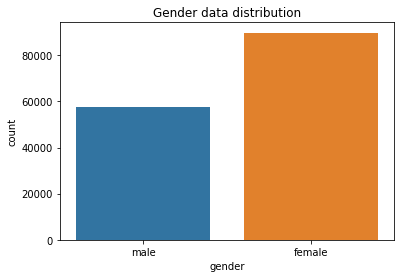

In [13]:
df['gender'].value_counts()
print("Total gender counts = ", df['gender'].value_counts()[0])
ax = sns.countplot(x=df['gender']).set(title='Gender data distribution')

In [14]:
def to_numeric(gender):
  """
  Convert gender type
  to numeric
  """
  if gender == "female":
      return 0
  elif gender == "male":
      return 1

In [15]:
df["label"] = df["gender"].apply(lambda x: to_numeric(x))
df

,first_name,gender,label
0,James,male,1
1,John,male,1
2,Robert,male,1
3,Michael,male,1
4,William,male,1
...,...,...,...
147264,Zylenn,male,1
147265,Zymeon,male,1
147266,Zyndel,male,1
147267,Zyshan,male,1


In [16]:
df[["first_name", "label"]]

,first_name,label
0,James,1
1,John,1
2,Robert,1
3,Michael,1
4,William,1
...,...,...
147264,Zylenn,1
147265,Zymeon,1
147266,Zyndel,1
147267,Zyshan,1


In [17]:
def split(df):
  """
  Split into train, val, test sets
  """
  train, temp = train_test_split(df, test_size=0.2)
  val, test = train_test_split(temp, test_size=0.5)

  return train, val, test

In [18]:
# Shuffle dataset

df = df.sample(frac=1).reset_index(drop=True)
df

,first_name,gender,label
0,Levanah,female,0
1,Katlan,female,0
2,Assuero,male,1
3,Deborra,female,0
4,Latania,female,0
...,...,...,...
147264,Music,female,0
147265,Mats,male,1
147266,Chhagana,female,0
147267,Kynsleigh,female,0


In [19]:
df = df[['first_name', 'label']]
df

,first_name,label
0,Levanah,0
1,Katlan,0
2,Assuero,1
3,Deborra,0
4,Latania,0
...,...,...
147264,Music,0
147265,Mats,1
147266,Chhagana,0
147267,Kynsleigh,0


In [20]:
train, val, test = split(df)
len(train), len(val), len(test)

(117815, 14727, 14727)

In [21]:
train

,first_name,label
105654,Sumella,0
102060,Janaya,0
20563,Aaroh,1
139123,Arpan,1
8267,Aneida,0
...,...,...
90225,Lucy,0
75519,Sohaila,0
41613,Anajah,0
54114,Pancho,1


In [22]:
train['label'].value_counts()

0    71957
1    45858
Name: label, dtype: int64

In [23]:
val['label'].value_counts()

0    8968
1    5759
Name: label, dtype: int64

In [24]:
test['label'].value_counts()

0    8824
1    5903
Name: label, dtype: int64

In [26]:
train_first_names = train['first_name'].tolist()
val_first_names = val['first_name'].tolist()
test_first_names = test['first_name'].tolist()

train_labels = train['label'].tolist()
val_labels = val['label'].tolist()
test_labels = test['label'].tolist()

In [27]:
train_samples = []
val_samples = []
test_samples = []

In [28]:
for first_name, label in list(zip(train_first_names, train_labels)):
    train_samples.append(InputExample(texts=[first_name], label=label))

In [29]:
(train_samples[0].texts, train_samples[0].label)

(['Sumella'], 0)

In [30]:
(train_samples[1].texts, train_samples[1].label)

(['Janaya'], 0)

In [31]:
(train_samples[2].texts, train_samples[2].label)

(['Aaroh'], 1)

In [32]:
for first_name, label in list(zip(val_first_names, val_labels)):
    val_samples.append(InputExample(texts=[first_name], label=label))

In [33]:
(val_samples[0].texts, val_samples[0].label)

(['Ann-Michelle'], 0)

In [34]:
(val_samples[1].texts, val_samples[1].label)

(['Johnallen'], 1)

In [35]:
(val_samples[2].texts, val_samples[2].label)

(['Lener'], 0)

In [36]:
for first_name, label in list(zip(test_first_names, test_labels)):
    test_samples.append(InputExample(texts=[first_name], label=label))

In [37]:
(test_samples[0].texts, test_samples[0].label)

(['Christothea'], 0)

In [38]:
(test_samples[1].texts, test_samples[1].label)

(['Yara'], 0)

In [39]:
(test_samples[2].texts, test_samples[2].label)

(['Jaystin'], 1)

In [40]:
train_batch_size = 32
num_epochs = 10

output_path = "models/gender_name_detection"
model_save_path = f'{output_path}/'+datetime.now().strftime("%Y%m%d%H%M")
model_save_path

'models/gender_name_detection/202303090944'

In [41]:
#Define our CrossEncoder model
target_names = ["female", "male"]
model = CrossEncoder('sentence-transformers/all-MiniLM-L12-v2', num_labels=len(target_names))

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at sentence-transformers/all-MiniLM-L12-v2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [42]:
#We wrap train_samples, which is a list ot InputExample, in a pytorch DataLoader
train_dataloader = DataLoader(train_samples, shuffle=True, batch_size=train_batch_size)

In [43]:
#During training, we use CEBinaryClassificationEvaluator to measure the accuracy on the dev set.
evaluator = CESoftmaxAccuracyEvaluator.from_input_examples(val_samples)

In [44]:
#### Just some code to print debug information to stdout
logging.basicConfig(format='%(asctime)s - %(message)s',
                    datefmt='%Y-%m-%d %H:%M:%S',
                    level=logging.INFO,
                    handlers=[LoggingHandler()])
logger = logging.getLogger(__name__)

In [45]:
warmup_steps = math.ceil(len(train_dataloader) * num_epochs * 0.1) #10% of train data for warm-up
logger.info("Warmup-steps: {}".format(warmup_steps))

In [46]:
# Train the model
model.fit(train_dataloader=train_dataloader,
          evaluator=evaluator,
          epochs=num_epochs,
          evaluation_steps=10000,
          warmup_steps=warmup_steps,
          output_path=model_save_path)

Epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Iteration:   0%|          | 0/3682 [00:00<?, ?it/s]

Iteration:   0%|          | 0/3682 [00:00<?, ?it/s]

Iteration:   0%|          | 0/3682 [00:00<?, ?it/s]

Iteration:   0%|          | 0/3682 [00:00<?, ?it/s]

Iteration:   0%|          | 0/3682 [00:00<?, ?it/s]

Iteration:   0%|          | 0/3682 [00:00<?, ?it/s]

Iteration:   0%|          | 0/3682 [00:00<?, ?it/s]

Iteration:   0%|          | 0/3682 [00:00<?, ?it/s]

Iteration:   0%|          | 0/3682 [00:00<?, ?it/s]

Iteration:   0%|          | 0/3682 [00:00<?, ?it/s]

In [47]:
model_save_path

'models/gender_name_detection/202303090944'

In [48]:
##### Load model and eval on test set
model = CrossEncoder(model_save_path)

In [49]:
evaluator = CESoftmaxAccuracyEvaluator.from_input_examples(test_samples, name='sts-test')
evaluator(model)

0.8002987709648944

In [50]:
model.predict(['Dacian'])

array([-1.3691788,  1.4934616], dtype=float32)

In [51]:
model.predict(['Cicilia'])

array([ 1.9406806, -2.0980473], dtype=float32)

In [52]:
model.predict(['Gheorghe'])

array([ 0.6455991, -0.7104236], dtype=float32)

In [53]:
model.predict(['Anamaria'])

array([ 2.043319 , -2.2083657], dtype=float32)

In [54]:
model.predict(['Nattiya'])

array([ 1.8182532, -1.9765562], dtype=float32)

In [55]:
preds = model.predict(
    ['Dacian'],
    apply_softmax=True
)
preds = preds.argmax(axis=0)
preds

1

In [56]:
preds = model.predict(
    ['Laura'],
    apply_softmax=True
)
preds = preds.argmax(axis=0)
preds

0

In [57]:
target_names = ["female", "male"]
target_names

['female', 'male']

In [58]:
%pprint

test_labels = test["label"].tolist()
test_labels = [
    target_names[label] for label in test_labels
]
test_labels

Pretty printing has been turned OFF


['female', 'female', 'male', 'female', 'male', 'male', 'male', 'female', 'female', 'female', 'female', 'female', 'male', 'female', 'female', 'male', 'male', 'male', 'female', 'female', 'female', 'female', 'female', 'female', 'female', 'male', 'female', 'female', 'male', 'female', 'female', 'male', 'female', 'female', 'female', 'male', 'female', 'female', 'female', 'female', 'female', 'female', 'female', 'female', 'male', 'female', 'female', 'male', 'female', 'female', 'male', 'female', 'male', 'male', 'female', 'female', 'female', 'female', 'male', 'female', 'male', 'male', 'male', 'male', 'male', 'male', 'male', 'male', 'male', 'female', 'female', 'female', 'female', 'male', 'male', 'female', 'male', 'female', 'female', 'male', 'male', 'female', 'female', 'female', 'male', 'male', 'male', 'male', 'male', 'male', 'female', 'female', 'female', 'female', 'male', 'female', 'female', 'male', 'female', 'male', 'female', 'female', 'female', 'female', 'female', 'male', 'female', 'male', 'fema

In [59]:
test_first_names = test["first_name"].tolist()
test_first_names

['Christothea', 'Yara', 'Jaystin', 'Tangala', 'Themba', 'Domencio', 'Lamarion', 'Cheralee', 'Margelene', 'Amylia', 'Sharra', 'Ridhi', 'Haralabos', 'Eimear', 'Kayenat', 'Talhah', 'Damiam', 'Goce', 'Natahsa', 'Peria', 'Smt.Farhana', 'Richie', 'Ysabelle', 'Jeanina', 'Christianna', 'Dementrius', 'Merilee', 'Vyanah', 'Jedson', 'Samanthanicole', 'Lee-Jen', 'Aleph', 'Shantanique', 'Sienna-Mary', 'Twilla', 'Leondrae', 'Darel', 'Roshonna', 'Haneya', 'Kiran', 'Takeyla', 'Envi', 'Avaya', 'Lolana', 'Adin', 'Vandany', 'Roewyn', 'Tiegen', 'Lanaeh', 'Lili', 'Yamil', 'Lokesh', 'Tormaigh', 'Grange', 'Ashmita', 'Allisha', 'Taycie', 'Lyndzie', 'Lancaster', 'Parvathi', 'Arcadian', 'Kiven', 'Mykhail', 'Clarke', 'Basam', 'Coen', 'Caysey', 'Pat', 'Tawananyasha', 'Jeannee', 'Rosemay', 'Shai', 'Brieah', 'Jermery', 'Gavinjot', 'Jaymia', 'Emero', 'Amy', 'Meral', 'Megat', 'Fennec', 'Umima', 'Shashana', 'Yulliana', 'Jaidon', 'Jomes', 'Dharamvir', 'Marcion', 'Vaugh', 'Antinio', 'Jessely', 'Kelley-Ann', 'Shealene', 

In [60]:
def predict(first_name):
    """
    Predict label
    """
    preds = model.predict(sentences=[first_name], apply_softmax=True)
    label = target_names[preds.argmax(axis=0)]
    return label

In [61]:
pred_labels = [
    predict(first_name) for first_name in test_first_names
]
pred_labels

['female', 'female', 'male', 'female', 'female', 'male', 'male', 'female', 'female', 'female', 'female', 'female', 'male', 'male', 'female', 'female', 'male', 'male', 'female', 'female', 'female', 'female', 'female', 'female', 'female', 'male', 'female', 'female', 'male', 'female', 'female', 'male', 'female', 'female', 'female', 'female', 'male', 'female', 'female', 'female', 'female', 'female', 'female', 'female', 'male', 'female', 'female', 'female', 'female', 'female', 'male', 'male', 'female', 'male', 'female', 'female', 'female', 'female', 'male', 'female', 'female', 'male', 'male', 'male', 'male', 'male', 'female', 'male', 'female', 'female', 'female', 'female', 'female', 'male', 'male', 'female', 'female', 'female', 'female', 'female', 'male', 'female', 'female', 'female', 'male', 'male', 'male', 'male', 'male', 'male', 'male', 'female', 'female', 'female', 'male', 'female', 'female', 'male', 'male', 'female', 'female', 'female', 'male', 'female', 'female', 'female', 'male', 'ma

**Evaluation**

In [62]:
print(classification_report(test_labels, pred_labels, target_names=target_names))

              precision    recall  f1-score   support

      female       0.83      0.84      0.84      8824
        male       0.76      0.74      0.75      5903

    accuracy                           0.80     14727
   macro avg       0.79      0.79      0.79     14727
weighted avg       0.80      0.80      0.80     14727



In [63]:
micro_metrics = precision_recall_fscore_support(test_labels, pred_labels, average="micro")
micro_metrics

(0.8002987709648944, 0.8002987709648944, 0.8002987709648944, None)

In [64]:
macro_metrics = precision_recall_fscore_support(test_labels, pred_labels, average="macro")
macro_metrics

(0.7927567360935672, 0.7895271877215959, 0.7910023511067577, None)

In [65]:
wght_metrics = precision_recall_fscore_support(test_labels, pred_labels, average="weighted")
wght_metrics

(0.7994508363242407, 0.8002987709648944, 0.7997450563242777, None)

In [66]:
accuracy = accuracy_score(test_labels, pred_labels)
accuracy

0.8002987709648944

In [67]:
def plot_confusion_matrix(test_labels, pred_labels):
    """ Save plot confusion matrix using actual, predicted labels to a given output path  
        
    :param test_labels: list
    :param pred_labels: list
    """
    df = pd.DataFrame({'test_labels': test_labels, 'pred_labels': pred_labels}, columns=['test_labels', 'pred_labels'])
    cm_df = pd.crosstab(df['test_labels'], df['pred_labels'], rownames=['Actual'], colnames=['Predicted'], margins=True)
    plt.figure()
    ax = sns.heatmap(cm_df, annot=True, fmt="d")

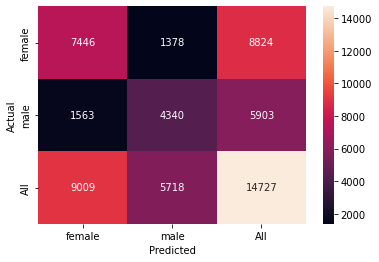

In [68]:
plot_confusion_matrix(test_labels, pred_labels)

In [69]:
test[test['label'] == 0]

,first_name,label
7871,Christothea,0
66764,Yara,0
147124,Tangala,0
138210,Cheralee,0
21407,Margelene,0
...,...,...
14297,Enasia,0
121547,Sharralee,0
72149,Haley-Jane,0
5578,Kaliopi,0


In [70]:
test[test['label'] == 0]['first_name'].tolist()

['Christothea', 'Yara', 'Tangala', 'Cheralee', 'Margelene', 'Amylia', 'Sharra', 'Ridhi', 'Eimear', 'Kayenat', 'Natahsa', 'Peria', 'Smt.Farhana', 'Richie', 'Ysabelle', 'Jeanina', 'Christianna', 'Merilee', 'Vyanah', 'Samanthanicole', 'Lee-Jen', 'Shantanique', 'Sienna-Mary', 'Twilla', 'Darel', 'Roshonna', 'Haneya', 'Kiran', 'Takeyla', 'Envi', 'Avaya', 'Lolana', 'Vandany', 'Roewyn', 'Lanaeh', 'Lili', 'Lokesh', 'Ashmita', 'Allisha', 'Taycie', 'Lyndzie', 'Parvathi', 'Jeannee', 'Rosemay', 'Shai', 'Brieah', 'Jaymia', 'Amy', 'Meral', 'Umima', 'Shashana', 'Yulliana', 'Jessely', 'Kelley-Ann', 'Shealene', 'Saquoia', 'Inshirah', 'Sofiya', 'Loey', 'Kashema', 'Myrtie', 'Yarimar', 'Rosvita', 'Arcangelina', 'Khenadi', 'Gitana', 'Avisha', 'Merlon', 'Mynasia', 'Jakyrah', 'Josselyne', 'Derianna', 'Prete', 'Dahja', 'Arlenne', 'Oliana', 'Vinci-Xanthe', 'Taleeya', 'Flay', 'Dolan', 'Ludij', 'Onesha', 'Nattie', 'Hayley-Lee', 'Bhavneeta', 'Tanae', 'Hannon', 'Eelyn', 'Astacia', 'Kasa', 'Rickia', 'Daeshawn', 'Iya